In [17]:
import netCDF4 as nc
import numpy as np
from numpy import ma
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.interpolate import griddata
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature

### Load the data

In [18]:
# Load the NetCDF file

# file_path = '/Users/zuhair/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/Research/current-projects/strain2D/Strain_2D/example/Output/gpsgridder/NC_files/I0.04_MYM_ITRF_gpsgridder_strain.nc'

file_path = '/Users/zuhair/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/Research/current-projects/strain-rate-seismicity/ntbk/Output_gpsgridder/I0.5_max_shear.nc'
ds = nc.Dataset(file_path)

# Load the earthquakedata
# earthquake_file_path = '../data/mainshocks_Reasenberg.csv'
earthquake_file_path = '../data/declustering/earthquakes-declustered.csv'
earthquake_data = pd.read_csv(earthquake_file_path)

# Check the available variables
print(ds.variables.keys())

# Extract the maximum shear strain rate
max_shear_strain = ds['max_shear'][:]
latitudes = ds['latitude'][:]
longitudes = ds['longitude'][:]

dict_keys(['latitude', 'longitude', 'max_shear'])


In [19]:
earthquake_data.columns

Index(['index', 'longitude', 'latitude', 'magnitude', 'sequential Days',
       'depth', 'date', 'year', 'month', 'day', 'hour', 'minute',
       'decimal Seconds'],
      dtype='object')

### Define Filtering Parameters:

In [20]:
# Define the region of interest
min_lat_roi, max_lat_roi = 16, 28
min_lon_roi, max_lon_roi = 95, 98

start_date = '1904-01-01'
end_date = '2022-12-31'
mc = 4.5
depth = 40

### Plot Grid Cells:

Here's a summary of the process and steps taken in the code:

1. **Define the Function to Plot Grid Cells:**
   - Created a function `plot_grid_cells` that takes `grid_size` and an `ax` (axis) for plotting.
   - Within this function:
     - Defined latitude and longitude bins based on the specified grid size.
     - Created a meshgrid over the region of interest using these bins.
     - Interpolated the strain rates onto the meshgrid.
     - Flattened the interpolated strain rates and sorted them in descending order.
     - Handled any NaN values in the sorted strain rates.
     - Filtered earthquake data within the region of interest and specified parameters.
     - Created an empty grid to count earthquakes within each cell of the grid.
     - Digitized the earthquake locations into the grid and incremented the count for each corresponding grid cell.
     - Masked the grid cells with zero earthquake counts to make them white in the plot.

2. **Plotting the Grid Cells and Earthquake Counts:**
   - Used Cartopy to plot the map with coastlines and gridlines.
   - Added gridlines with labels for better visualization.
   - Plotted the grid cells using `pcolormesh` to show the number of earthquakes within each cell, using a red color map.
   - Added a color bar to indicate the number of earthquakes.
   - Set the extent and labels for the plot, including the title indicating the grid size.

3. **Test Different Grid Sizes:**
   - Defined a list of grid sizes to test: `[0.1, 0.3, 0.5, 0.7]`.
   - Created subplots for each grid size in a single row using `plt.subplots`.
   - Called the `plot_grid_cells` function for each grid size, passing the respective axis for plotting.

### Importance and Purpose:

- **Purpose of Each Step:**
  - The import statements are essential for bringing in the necessary tools and functions for data processing and visualization.
  - Loading the data and defining the region of interest allow for targeted analysis within a specific geographic area.
  - Filtering the earthquake data ensures that the analysis focuses on relevant events based on magnitude, depth, and date.
  - Interpolating the strain rates onto the meshgrid helps in visualizing the spatial distribution of strain rates across the region.
  - Creating the grid and digitizing earthquake locations allow for aggregating earthquake counts within each grid cell.
  - Plotting the grid cells and earthquake counts on a map provides a visual representation of the seismic activity in relation to the strain rates.

- **Importance of the Analysis:**
  - This analysis is crucial for understanding the correlation between seismic activity and strain rates.
  - Visualizing the earthquake counts within grid cells helps identify areas with higher seismic activity.
  - Comparing different grid sizes allows for sensitivity analysis, which is important for validating the robustness of the results.
  - The visual representation aids in identifying patterns and anomalies in seismic activity, which can be useful for further research and disaster management planning.

Here is the code:

/Users/zuhair/anaconda3/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


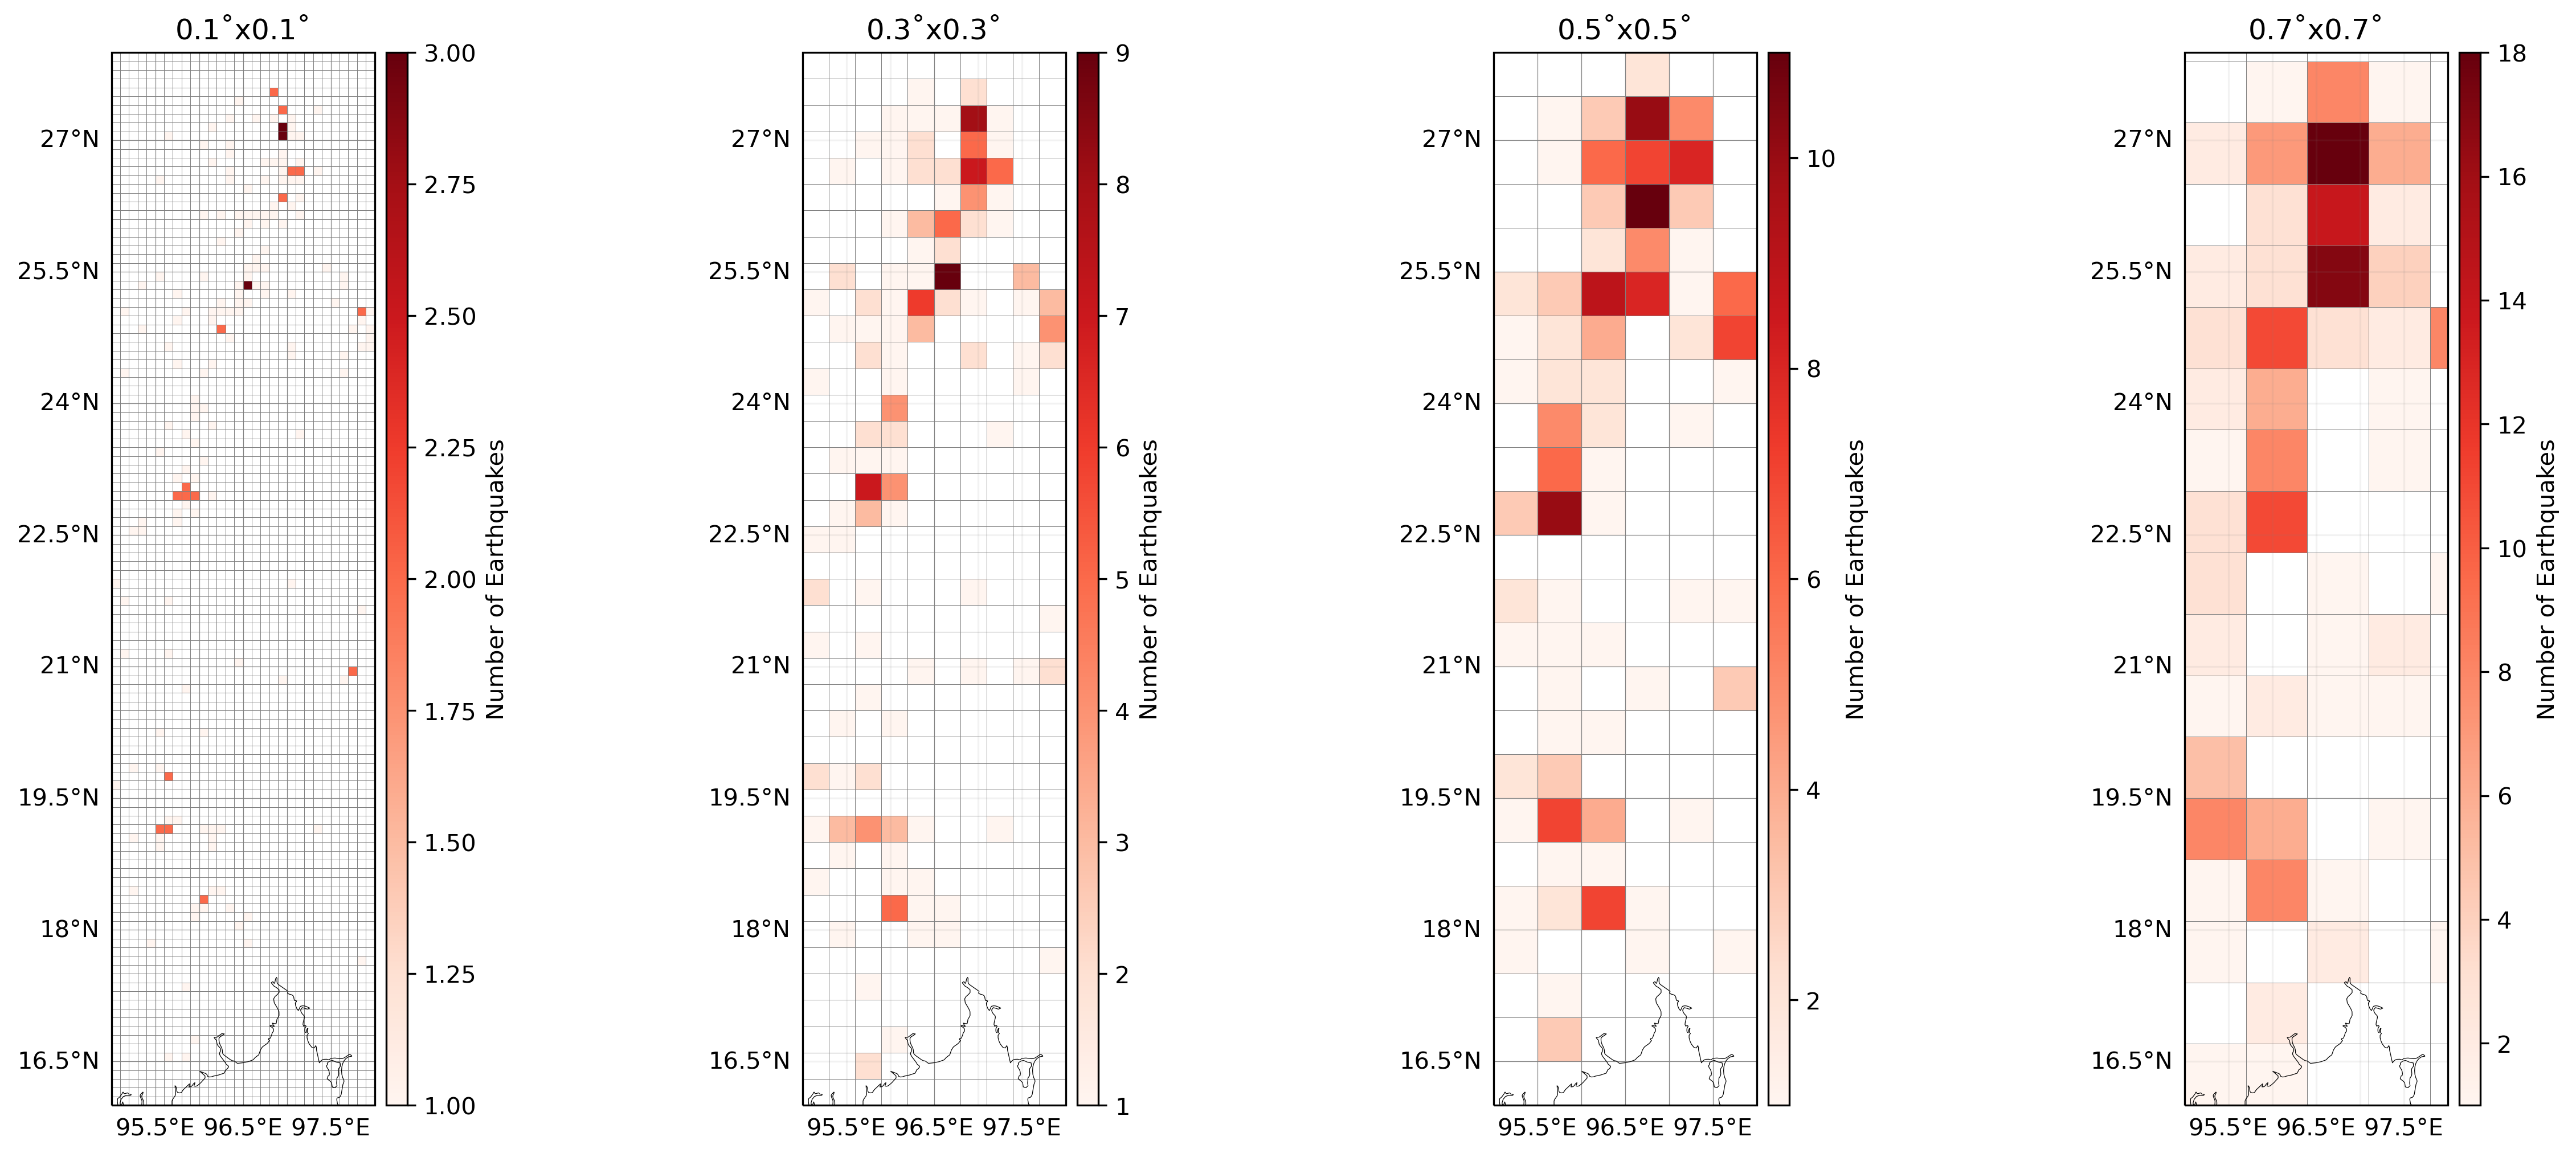

In [21]:
# Function to plot the cell boundaries on a map using Cartopy
def plot_grid_cells(grid_size, ax):
    # Define the grid parameters
    lat_bins = np.arange(min_lat_roi, max_lat_roi + grid_size, grid_size)
    lon_bins = np.arange(min_lon_roi, max_lon_roi + grid_size, grid_size)

    # Create a meshgrid for the region of interest
    lon_grid, lat_grid = np.meshgrid(lon_bins, lat_bins)

    # Interpolate the strain rates onto the grid
    points = np.array([(lon, lat) for lat in latitudes for lon in longitudes])
    values = max_shear_strain.flatten()
    interpolated_strain_rates = griddata(points, values, (lon_grid, lat_grid), method='linear')

    # Flatten the interpolated strain rates
    flattened_strain_rates = interpolated_strain_rates.flatten()
    sorted_indices = np.argsort(flattened_strain_rates)[::-1]
    sorted_strain_rates = flattened_strain_rates[sorted_indices]

    # Handle NaN values in sorted_strain_rates
    sorted_strain_rates = np.nan_to_num(sorted_strain_rates)

    # Filter the earthquake data for the region of interest, time period, completeness magnitude, and depth
    filtered_earthquake_locations_roi = earthquake_data[
        (earthquake_data['latitude'] >= min_lat_roi) &
        (earthquake_data['latitude'] <= max_lat_roi) &
        (earthquake_data['longitude'] >= min_lon_roi) &
        (earthquake_data['longitude'] <= max_lon_roi) &
        (earthquake_data['depth'] < depth)
    ]

    # Create an empty grid for earthquake counts
    earthquake_count_grid = np.zeros((len(lat_bins) - 1, len(lon_bins) - 1))

    # Digitize the filtered earthquake locations into the grid
    x_indices = np.digitize(filtered_earthquake_locations_roi['longitude'], lon_bins) - 1
    y_indices = np.digitize(filtered_earthquake_locations_roi['latitude'], lat_bins) - 1

    # Increment the earthquake count for each grid cell
    for x_idx, y_idx in zip(x_indices, y_indices):
        if 0 <= x_idx < earthquake_count_grid.shape[1] and 0 <= y_idx < earthquake_count_grid.shape[0]:
            earthquake_count_grid[y_idx, x_idx] += 1

    # Mask the earthquake count grid to make cells with zero earthquakes white
    masked_earthquake_count_grid = ma.masked_where(earthquake_count_grid == 0, earthquake_count_grid)

    # Plot the cell boundaries on a map using Cartopy
    ax.coastlines(resolution='10m', color='black', linewidth=0.3)
    # Add gridlines with labels
    gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.1, linestyle='-')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10, 'color': 'black', 'rotation': 0}
    gl.ylabel_style = {'size': 10, 'color': 'black'}

    # Plot the grid cells
    lon_grid_centered = (lon_bins[:-1] + lon_bins[1:]) / 2
    lat_grid_centered = (lat_bins[:-1] + lat_bins[1:]) / 2
    mesh_lon, mesh_lat = np.meshgrid(lon_grid_centered, lat_grid_centered)
    c = ax.pcolormesh(lon_bins, lat_bins, masked_earthquake_count_grid, cmap='Reds', alpha=1, edgecolor='gray', linewidth=0.2, transform=ccrs.PlateCarree())

    # Add colorbar
    cbar = plt.colorbar(c, ax=ax, orientation='vertical', pad=0.02, aspect=50)
    cbar.set_label('Number of Earthquakes')

    # Set extent and labels
    ax.set_extent([min_lon_roi, max_lon_roi, min_lat_roi, max_lat_roi], crs=ccrs.PlateCarree())
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'{grid_size}˚x{grid_size}˚')

# Define the grid sizes to test
grid_sizes = [0.1, 0.3, 0.5, 0.7]

# Create subplots for different grid sizes in a row
fig, axes = plt.subplots(1, 4, figsize=(20, 8), dpi=300, subplot_kw={'projection': ccrs.PlateCarree()})
for ax, grid_size in zip(axes, grid_sizes):
    plot_grid_cells(grid_size, ax)

# Save the figure to an 'output' folder
output_dir = 'output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
plt.savefig(os.path.join(output_dir, 'grid_resolution_tests.png'), bbox_inches='tight')

# Display the plot
plt.show()

### Potency Rate and Seismicity correlation:

1. **Define the Function to Perform Analysis for a Given Grid Size:**
   - Created a function `analyze_grid_size` that takes `grid_size` as input.
   - Within this function:
     - Defined latitude and longitude bins based on the specified grid size.
     - Created a meshgrid over the region of interest using these bins.
     - Interpolated the strain rates onto the meshgrid using `griddata`.
     - Flattened the interpolated strain rates and sorted them in descending order.
     - Handled any NaN values in the sorted strain rates.

2. **Filter Earthquake Data:**
   - Filtered the earthquake data within the region of interest based on latitude, longitude, date, magnitude, and depth.
   - Created an empty grid to count earthquakes within each cell of the grid.
   - Digitized the earthquake locations into the grid and incremented the count for each corresponding grid cell.
   - Flattened the earthquake count grid.
   - Ensured the lengths of the arrays (strain rates and earthquake counts) match.
   - Ensured `sorted_indices` contains valid indices for `flattened_earthquake_counts`.
   - Sorted the flattened earthquake counts to match the strain rate sorting.
   - Handled NaN values in the sorted strain rates.

3. **Calculate Geodetic Potency Rate and Normalize:**
   - Calculated the area of each grid cell (in km², assuming 1 degree ~ 111.32 km).
   - Filtered out zero strain rates.
   - Calculated the cumulative geodetic potency rate and normalized it.
   - Calculated cumulative earthquake counts and normalized them.

4. **Return the Normalized Cumulative Potency and Earthquake Counts:**
   - Returned the `normalized_cumulative_potency_rate` and `normalized_cumulative_earthquake_counts`.

5. **Define the Grid Sizes to Test:**
   - Defined a list of grid sizes to test: `[0.1, 0.3, 0.5, 0.7]`.

6. **Create Subplots for Different Grid Sizes in a Row:**
   - Created subplots for each grid size in a single row using `plt.subplots`.
   - Called the `analyze_grid_size` function for each grid size.
   - Plotted the normalized cumulative curves with enhanced visibility.
   - Added labels and titles to the subplots.
   - Added legends to the subplots.

### Importance and Purpose:

- **Purpose of Each Step:**
  - The import statements are essential for bringing in the necessary tools and functions for data processing and visualization.
  - Defining the function for analysis allows for modular and reusable code to perform the correlation analysis for different grid sizes.
  - Filtering the earthquake data ensures that the analysis focuses on relevant events based on magnitude, depth, and date.
  - Interpolating the strain rates onto the meshgrid helps in visualizing the spatial distribution of strain rates across the region.
  - Creating the grid and digitizing earthquake locations allow for aggregating earthquake counts within each grid cell.
  - Calculating the cumulative geodetic potency rate and normalizing it provides a standardized measure for comparison.
  - Plotting the normalized cumulative curves for different grid sizes allows for a comparative analysis of how grid size affects the correlation between strain rates and seismicity.

- **Importance of the Analysis:**
  - This analysis is crucial for understanding the correlation between seismic activity and strain rates.
  - Visualizing the earthquake counts within grid cells helps identify areas with higher seismic activity.
  - Comparing different grid sizes allows for sensitivity analysis, which is important for validating the robustness of the results.
  - The visual representation aids in identifying patterns and anomalies in seismic activity, which can be useful for further research and disaster management planning.
 
Here is the code:

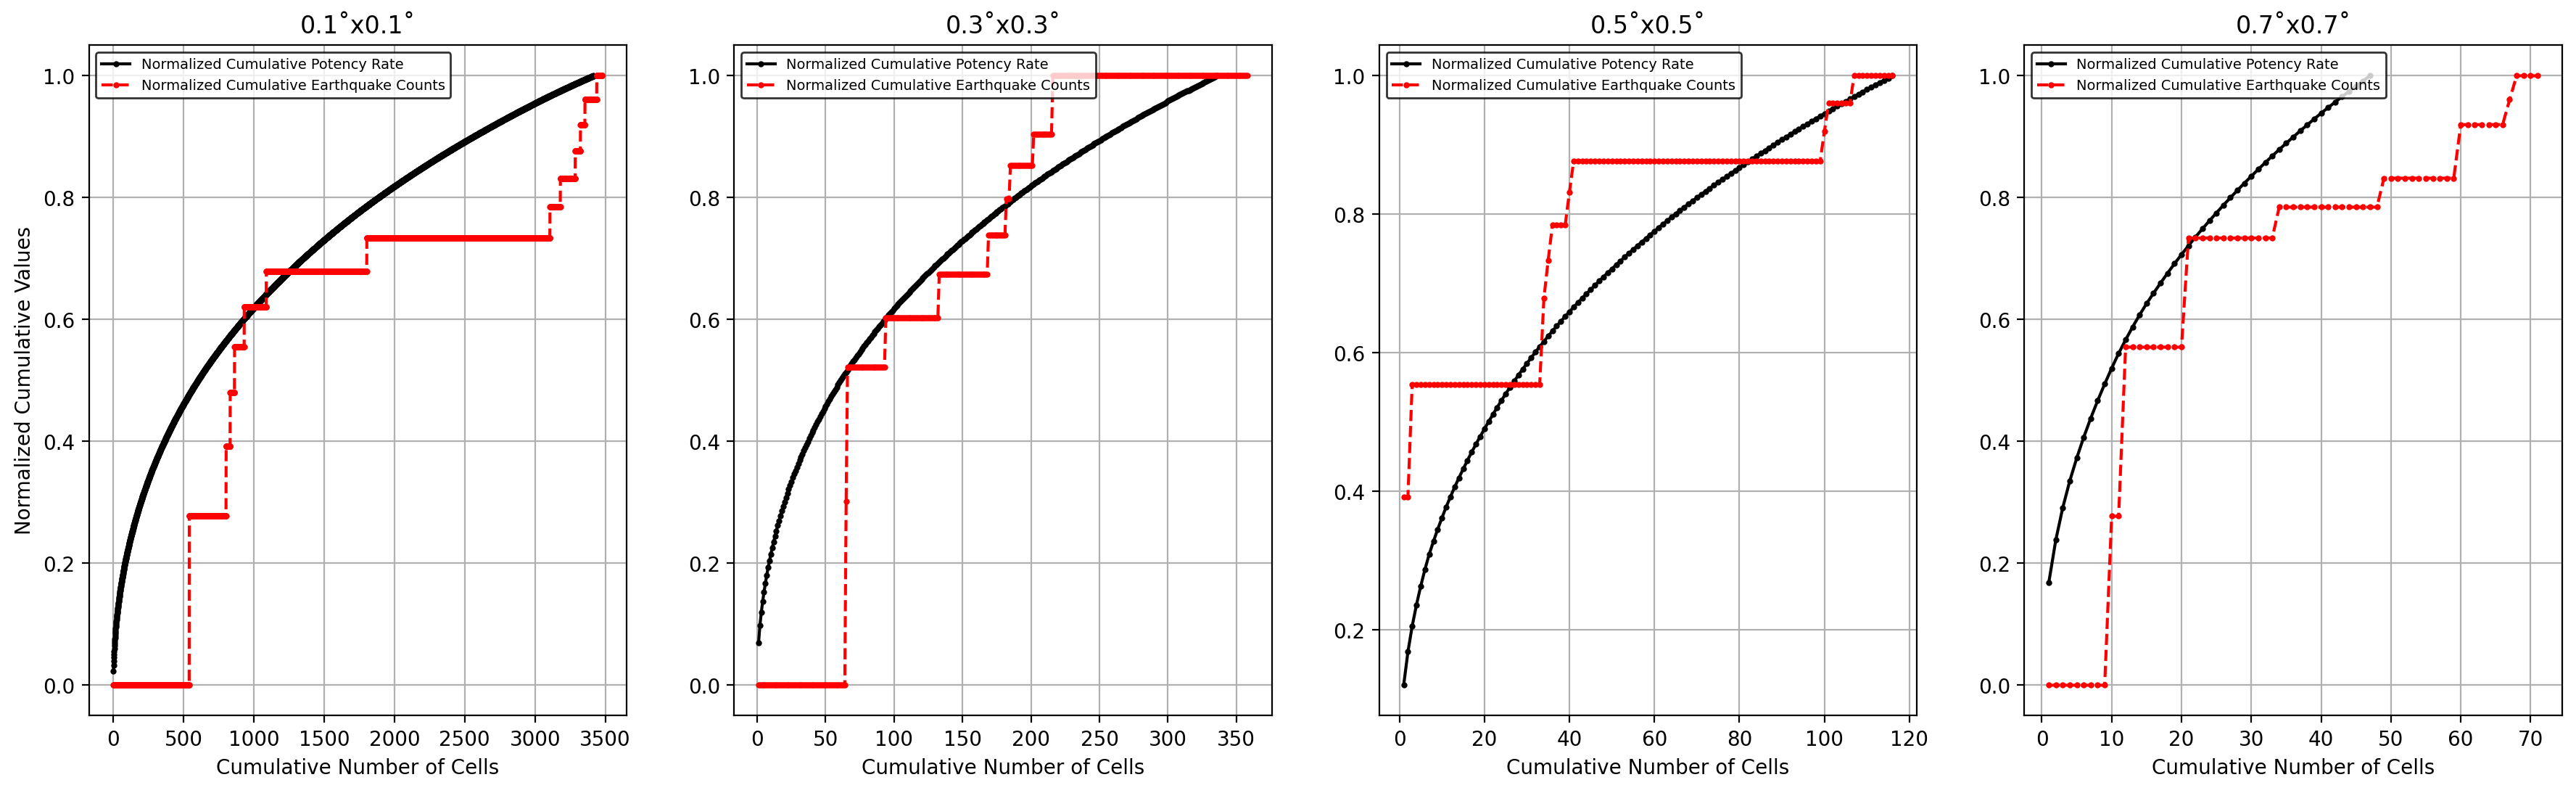

In [22]:
# Function to perform the analysis for a given grid size
def analyze_grid_size(grid_size):
    # Define the grid parameters
    lat_bins = np.arange(min_lat_roi, max_lat_roi + grid_size, grid_size)
    lon_bins = np.arange(min_lon_roi, max_lon_roi + grid_size, grid_size)

    # Create a meshgrid for the region of interest
    lon_grid, lat_grid = np.meshgrid(lon_bins, lat_bins)

    # Interpolate the strain rates onto the grid
    points = np.array([(lon, lat) for lat in latitudes for lon in longitudes])
    values = max_shear_strain.flatten()
    interpolated_strain_rates = griddata(points, values, (lon_grid, lat_grid), method='linear')

    # Flatten the interpolated strain rates
    flattened_strain_rates = interpolated_strain_rates.flatten()
    sorted_indices = np.argsort(flattened_strain_rates)[::-1]
    sorted_strain_rates = flattened_strain_rates[sorted_indices]

    # Handle NaN values in sorted_strain_rates
    sorted_strain_rates = np.nan_to_num(sorted_strain_rates)

    # Filter the earthquake data for the region of interest, time period, completeness magnitude, and depth
    filtered_earthquake_locations_roi = earthquake_data[
        (earthquake_data['latitude'] >= min_lat_roi) &
        (earthquake_data['latitude'] <= max_lat_roi) &
        (earthquake_data['longitude'] >= min_lon_roi) &
        (earthquake_data['longitude'] <= max_lon_roi) &
        (earthquake_data['date'] >= start_date) &
        (earthquake_data['date'] <= end_date) &
        (earthquake_data['magnitude'] >= mc) &
        (earthquake_data['depth'] < depth)
    ]

    # Create an empty grid for earthquake counts
    earthquake_count_grid = np.zeros((len(lat_bins) - 1, len(lon_bins) - 1))

    # Digitize the filtered earthquake locations into the grid
    x_indices = np.digitize(filtered_earthquake_locations_roi['longitude'], lon_bins) - 1
    y_indices = np.digitize(filtered_earthquake_locations_roi['latitude'], lat_bins) - 1

    # Increment the earthquake count for each grid cell
    for x_idx, y_idx in zip(x_indices, y_indices):
        if 0 <= x_idx < earthquake_count_grid.shape[1] and 0 <= y_idx < earthquake_count_grid.shape[0]:
            earthquake_count_grid[y_idx, x_idx] += 1

    # Flatten the earthquake count grid
    flattened_earthquake_counts = earthquake_count_grid.flatten()

    # Ensure the lengths of the arrays match
    min_length = min(len(sorted_indices), len(flattened_strain_rates), len(flattened_earthquake_counts))
    sorted_indices = sorted_indices[:min_length]
    sorted_strain_rates = sorted_strain_rates[:min_length]
    flattened_earthquake_counts = flattened_earthquake_counts[:min_length]

    # Ensure sorted_indices contains valid indices for flattened_earthquake_counts
    valid_sorted_indices = [idx for idx in sorted_indices if idx < len(flattened_earthquake_counts)]

    # Sort the flattened earthquake counts to match the strain rate sorting
    sorted_earthquake_counts = flattened_earthquake_counts[valid_sorted_indices]
    sorted_strain_rates = sorted_strain_rates[:len(valid_sorted_indices)]

    # Handle NaN values in sorted_strain_rates
    sorted_strain_rates = np.nan_to_num(sorted_strain_rates)

    # Calculate the area of each grid cell (in km², assuming 1 degree ~ 111.32 km)
    grid_cell_area = (111.32 * grid_size) * (111.32 * grid_size)

    # Filter out zero strain rates
    non_zero_strain_rates = sorted_strain_rates[sorted_strain_rates > 0]

    # Calculate the cumulative geodetic potency rate and normalize
    cumulative_potency_rate = np.cumsum(non_zero_strain_rates * grid_cell_area)
    power_cumulative_potency_rate = np.power(cumulative_potency_rate, 0.5)  # Example with square root
    normalized_cumulative_potency_rate = power_cumulative_potency_rate / power_cumulative_potency_rate[-1]
#     normalized_cumulative_potency_rate = cumulative_potency_rate / cumulative_potency_rate[-1] if cumulative_potency_rate[-1] != 0 else np.zeros_like(cumulative_potency_rate)


    # Calculate cumulative earthquake counts and normalize
    cumulative_earthquake_counts = np.cumsum(sorted_earthquake_counts)
    power_cumulative_earthquake_counts = np.power(cumulative_earthquake_counts, 0.5)  # Example with square root
    normalized_cumulative_earthquake_counts = power_cumulative_earthquake_counts / power_cumulative_earthquake_counts[-1]
#     normalized_cumulative_earthquake_counts = cumulative_earthquake_counts / cumulative_earthquake_counts[-1] if cumulative_earthquake_counts[-1] != 0 else np.zeros_like(cumulative_earthquake_counts)

    return normalized_cumulative_potency_rate, normalized_cumulative_earthquake_counts
#     return interpolated_strain_rates, sorted_strain_rates, flattened_earthquake_counts, normalized_cumulative_potency_rate, normalized_cumulative_earthquake_counts, lon_grid, lat_grid, filtered_earthquake_locations_roi


# Define the grid sizes to test
grid_sizes = [0.1, 0.3, 0.5, 0.7]

# Create subplots for different grid sizes in a row
fig, axes = plt.subplots(1, 4, figsize=(22, 6), dpi=200)
for i, (ax, grid_size) in enumerate(zip(axes, grid_sizes)):
    norm_potency_rate, norm_earthquake_counts = analyze_grid_size(grid_size)
    
    # Plot the normalized cumulative curves with enhanced visibility
    ax.plot(range(1, len(norm_potency_rate) + 1), norm_potency_rate, label='Normalized Cumulative Potency Rate', marker='o', color='k', markersize = 2)
    ax.plot(range(1, len(norm_earthquake_counts) + 1), norm_earthquake_counts, label='Normalized Cumulative Earthquake Counts', linestyle='--', marker='o', color='r', markersize = 2)
    ax.set_xlabel('Cumulative Number of Cells')
    if i == 0:
        ax.set_ylabel('Normalized Cumulative Values')
    ax.set_title(f'{grid_size}˚x{grid_size}˚')
    ax.legend(fontsize='7', loc='upper left', frameon=True, facecolor='white', edgecolor='k')
    ax.grid(True)

# Save the figure to an 'output' folder
# output_dir = 'output'
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)
# plt.savefig(os.path.join(output_dir, 'correlation_test_comparison.png'), bbox_inches='tight')

# Display the plot
plt.show()

### Correlation test for different time periods of seismicity:

1. **Define the Function to Calculate and Plot Cumulative Potency and Earthquake Counts:**
   - Created a function `plot_cumulative_potency_and_earthquake_counts` that takes `grid_size`, `ax` (axis), and `first_col` as inputs.
   - Within this function:
     - Defined latitude and longitude bins based on the specified grid size.
     - Created a meshgrid over the region of interest using these bins.
     - Interpolated the strain rates onto the meshgrid using `griddata`.
     - Flattened the interpolated strain rates and sorted them in descending order.
     - Handled any NaN values in the sorted strain rates.

2. **Filter Earthquake Data:**
   - Filtered the earthquake data within the region of interest based on latitude, longitude, date, magnitude, and depth.
   - Created an empty grid to count earthquakes within each cell of the grid.
   - Digitized the earthquake locations into the grid and incremented the count for each corresponding grid cell.
   - Flattened the earthquake count grid.
   - Ensured the lengths of the arrays (strain rates and earthquake counts) match.
   - Ensured `sorted_indices` contains valid indices for `flattened_earthquake_counts`.
   - Sorted the flattened earthquake counts to match the strain rate sorting.
   - Handled NaN values in the sorted strain rates.

3. **Calculate Geodetic Potency Rate and Normalize:**
   - Calculated the area of each grid cell (in km², assuming 1 degree ~ 111.32 km).
   - Filtered out zero strain rates.
   - Calculated the cumulative geodetic potency rate and normalized it.
   - Calculated cumulative earthquake counts and normalized them.

4. **Calculate Cumulative Earthquake Counts for Each Moving Window:**
   - Defined the moving window parameters (start year, end year, window size, and step size).
   - Prepared to store cumulative earthquake counts for each window.
   - For each window:
     - Filtered earthquake data within the window period.
     - Digitized the earthquake locations into the grid.
     - Calculated cumulative earthquake counts for the window and normalized them.
     - Stored the normalized cumulative counts for each window.

5. **Plot the Cumulative Potency Rate and Earthquake Counts:**
   - Plotted the normalized cumulative potency rate in black.
   - Defined the color map for plotting the cumulative earthquake counts.
   - Plotted the normalized cumulative earthquake counts for each window using different colors for each time period.
   - Customized the plot with labels, titles, and gridlines.

6. **Create Subplots for Different Grid Sizes:**
   - Created subplots for each grid size in a single row using `plt.subplots`.
   - Called the `plot_cumulative_potency_and_earthquake_counts` function for each grid size, passing the respective axis for plotting.

7. **Add a Single Colorbar on the Far Right:**
   - Added a single colorbar to the figure to indicate the midyear of the moving window.

### Importance and Purpose:

- **Purpose of Each Step:**
  - Defining the function for analysis allows for modular and reusable code to perform the correlation analysis for different grid sizes.
  - Filtering the earthquake data ensures that the analysis focuses on relevant events based on magnitude, depth, and date.
  - Interpolating the strain rates onto the meshgrid helps in visualizing the spatial distribution of strain rates across the region.
  - Creating the grid and digitizing earthquake locations allow for aggregating earthquake counts within each grid cell.
  - Calculating the cumulative geodetic potency rate and normalizing it provides a standardized measure for comparison.
  - Calculating cumulative earthquake counts for each moving window allows for a temporal analysis of seismic activity.
  - Plotting the cumulative potency rate and earthquake counts for different grid sizes allows for a comparative analysis of how grid size affects the correlation between strain rates and seismicity.
  - Adding a single colorbar provides a clear visual representation of the time periods for the moving windows.

- **Importance of the Analysis:**
  - This analysis is crucial for understanding the correlation between seismic activity and strain rates.
  - Visualizing the earthquake counts within grid cells helps identify areas with higher seismic activity.
  - Comparing different grid sizes allows for sensitivity analysis, which is important for validating the robustness of the results.
  - The temporal analysis of seismic activity helps in identifying patterns and anomalies over time, which can be useful for further research and disaster management planning.

Here is the code:

In [23]:
# # import numpy as np
# # import matplotlib.pyplot as plt
# # from scipy.interpolate import griddata

# # Function to perform the analysis for a given grid size
# def analyze_grid_size(grid_size):
#     # Define the grid parameters
#     lat_bins = np.arange(min_lat_roi, max_lat_roi + grid_size, grid_size)
#     lon_bins = np.arange(min_lon_roi, max_lon_roi + grid_size, grid_size)

#     # Create a meshgrid for the region of interest
#     lon_grid, lat_grid = np.meshgrid(lon_bins, lat_bins)

#     # Interpolate the strain rates onto the grid
#     points = np.array([(lon, lat) for lat in latitudes for lon in longitudes])
#     values = max_shear_strain.flatten()
#     interpolated_strain_rates = griddata(points, values, (lon_grid, lat_grid), method='linear')

#     # Flatten the interpolated strain rates
#     flattened_strain_rates = interpolated_strain_rates.flatten()
#     sorted_indices = np.argsort(flattened_strain_rates)[::-1]
#     sorted_strain_rates = flattened_strain_rates[sorted_indices]

#     # Handle NaN values in sorted_strain_rates
#     sorted_strain_rates = np.nan_to_num(sorted_strain_rates)

#     # Filter the earthquake data for the region of interest, time period, completeness magnitude, and depth
#     filtered_earthquake_locations_roi = earthquake_data[
#         (earthquake_data['latitude'] >= min_lat_roi) &
#         (earthquake_data['latitude'] <= max_lat_roi) &
#         (earthquake_data['longitude'] >= min_lon_roi) &
#         (earthquake_data['longitude'] <= max_lon_roi) &
#         (earthquake_data['date'] >= start_date) &
#         (earthquake_data['date'] <= end_date) &
#         (earthquake_data['magnitude'] >= mc) &
#         (earthquake_data['depth'] < depth)
#     ]

#     # Create an empty grid for earthquake counts
#     earthquake_count_grid = np.zeros((len(lat_bins) - 1, len(lon_bins) - 1))

#     # Digitize the filtered earthquake locations into the grid
#     x_indices = np.digitize(filtered_earthquake_locations_roi['longitude'], lon_bins) - 1
#     y_indices = np.digitize(filtered_earthquake_locations_roi['latitude'], lat_bins) - 1

#     # Increment the earthquake count for each grid cell
#     for x_idx, y_idx in zip(x_indices, y_indices):
#         if 0 <= x_idx < earthquake_count_grid.shape[1] and 0 <= y_idx < earthquake_count_grid.shape[0]:
#             earthquake_count_grid[y_idx, x_idx] += 1

#     # Flatten the earthquake count grid
#     flattened_earthquake_counts = earthquake_count_grid.flatten()

#     # Ensure the lengths of the arrays match
#     min_length = min(len(sorted_indices), len(flattened_strain_rates), len(flattened_earthquake_counts))
#     sorted_indices = sorted_indices[:min_length]
#     sorted_strain_rates = sorted_strain_rates[:min_length]
#     flattened_earthquake_counts = flattened_earthquake_counts[:min_length]

#     # Ensure sorted_indices contains valid indices for flattened_earthquake_counts
#     valid_sorted_indices = [idx for idx in sorted_indices if idx < len(flattened_earthquake_counts)]

#     # Sort the flattened earthquake counts to match the strain rate sorting
#     sorted_earthquake_counts = flattened_earthquake_counts[valid_sorted_indices]
#     sorted_strain_rates = sorted_strain_rates[:len(valid_sorted_indices)]

#     # Handle NaN values in sorted_strain_rates
#     sorted_strain_rates = np.nan_to_num(sorted_strain_rates)

#     # Calculate the area of each grid cell (in km², assuming 1 degree ~ 111.32 km)
#     grid_cell_area = (111.32 * grid_size) * (111.32 * grid_size)

#     # Filter out zero strain rates
#     non_zero_strain_rates = sorted_strain_rates[sorted_strain_rates > 0]

#     # Calculate the cumulative geodetic potency rate and normalize
#     cumulative_potency_rate = np.cumsum(non_zero_strain_rates * grid_cell_area)
#     power_cumulative_potency_rate = np.power(cumulative_potency_rate, 0.5)  # Example with square root
#     normalized_cumulative_potency_rate = power_cumulative_potency_rate / power_cumulative_potency_rate[-1]

#     # Calculate cumulative earthquake counts and normalize
#     cumulative_earthquake_counts = np.cumsum(sorted_earthquake_counts)
#     power_cumulative_earthquake_counts = np.power(cumulative_earthquake_counts, 0.5)  # Example with square root
#     normalized_cumulative_earthquake_counts = power_cumulative_earthquake_counts / power_cumulative_earthquake_counts[-1]

#     return normalized_cumulative_potency_rate, normalized_cumulative_earthquake_counts

# # Define the grid size to test
# grid_size = 0.5  # Example grid size

# # Perform the analysis for the specified grid size
# norm_potency_rate, norm_earthquake_counts = analyze_grid_size(grid_size)

# # Plot the normalized cumulative curves with enhanced visibility
# plt.figure(figsize=(6, 6), dpi=200)
# plt.plot(range(1, len(norm_potency_rate) + 1), norm_potency_rate, label='Normalized Cumulative Potency Rate', marker='o', color='k', markersize=2)
# plt.plot(range(1, len(norm_earthquake_counts) + 1), norm_earthquake_counts, label='Normalized Cumulative Earthquake Counts', linestyle='--', marker='o', color='r', markersize=2)
# plt.xlabel('Cumulative Number of Cells')
# plt.ylabel('Normalized Cumulative Values')
# plt.title(f'{grid_size}˚x{grid_size}˚')
# plt.legend(fontsize='7', loc='upper left', frameon=True, facecolor='white', edgecolor='k')
# plt.grid(True)
# # Apply xlim and ylim
# plt.xlim(0, len(norm_potency_rate))  # Example xlim, modify as needed
# plt.ylim(0, 1)  # Example ylim, modify as needed

# # Save the figure to an 'output' folder
# # output_dir = 'output'
# # if not os.path.exists(output_dir):
# #     os.makedirs(output_dir)
# # plt.savefig(os.path.join(output_dir, 'correlation_test_comparison.png'), bbox_inches='tight')

# # Display the plot
# plt.show()

In [24]:

# # Define the region of interest and grid size
# min_lat_roi, max_lat_roi = 16, 28
# min_lon_roi, max_lon_roi = 95, 98
# grid_size = 0.5

# # Generate grid bins
# lat_bins = np.arange(min_lat_roi, max_lat_roi + grid_size, grid_size)
# lon_bins = np.arange(min_lon_roi, max_lon_roi + grid_size, grid_size)

# # Create a grid to count the number of earthquakes in each cell
# earthquake_count_grid = np.zeros((len(lat_bins) - 1, len(lon_bins) - 1))

# # Digitize earthquake locations into the grid
# x_indices = np.digitize(filtered_earthquake_locations_roi['longitude'], lon_bins) - 1
# y_indices = np.digitize(filtered_earthquake_locations_roi['latitude'], lat_bins) - 1

# # Increment the earthquake count for each grid cell
# for x_idx, y_idx in zip(x_indices, y_indices):
#     if 0 <= x_idx < earthquake_count_grid.shape[1] and 0 <= y_idx < earthquake_count_grid.shape[0]:
#         earthquake_count_grid[y_idx, x_idx] += 1

# # Interpolating strain rates onto the grid
# lon_grid, lat_grid = np.meshgrid(lon_bins, lat_bins)
# points = np.array([(lon, lat) for lat in latitudes for lon in longitudes])
# values = max_shear_strain.flatten()
# interpolated_strain_rates = griddata(points, values, (lon_grid, lat_grid), method='linear')

# # Plotting the earthquake count grid
# fig, ax = plt.subplots(figsize=(6, 10), dpi=100, subplot_kw={'projection': ccrs.PlateCarree()})
# ax.set_extent([min_lon_roi, max_lon_roi, min_lat_roi, max_lat_roi], crs=ccrs.PlateCarree())

# # Plot the grid counts
# c1 = ax.pcolormesh(lon_bins, lat_bins, earthquake_count_grid, cmap='Reds', edgecolor='k')

# # Add a colorbar for earthquake counts
# cbar1 = plt.colorbar(c1, ax=ax, orientation='vertical', pad=0.01)
# cbar1.set_label('Number of Earthquakes')

# # Add features
# ax.coastlines(resolution='10m', color='black', linewidth=0.5)
# ax.add_feature(cfeature.BORDERS, linestyle=':')
# ax.gridlines(draw_labels=True, color='gray', alpha=0.5, linestyle='--')

# plt.title(f'Earthquake Count Grid: {grid_size}°x{grid_size}°')
# plt.show()

# # Plotting the strain rates grid
# fig, ax = plt.subplots(figsize=(6, 10), dpi=100, subplot_kw={'projection': ccrs.PlateCarree()})
# ax.set_extent([min_lon_roi, max_lon_roi, min_lat_roi, max_lat_roi], crs=ccrs.PlateCarree())

# # Plot the strain rates
# c2 = ax.pcolormesh(lon_grid, lat_grid, interpolated_strain_rates, cmap='viridis', edgecolor='k')

# # Add a colorbar for strain rates
# cbar2 = plt.colorbar(c2, ax=ax, orientation='vertical', pad=0.01)
# cbar2.set_label('Strain Rate')

# # Add features
# ax.coastlines(resolution='10m', color='black', linewidth=0.5)
# ax.add_feature(cfeature.BORDERS, linestyle=':')
# ax.gridlines(draw_labels=True, color='gray', alpha=0.5, linestyle='--')

# # plt.title(f'Strain Rate Grid: {grid_size}°x{grid_size}°')
# plt.show()

In [25]:
# # Function to calculate and plot cumulative potency and earthquake counts
# def plot_cumulative_potency_and_earthquake_counts(grid_size, ax, first_col):
#     # Define the grid parameters
#     lat_bins = np.arange(min_lat_roi, max_lat_roi + grid_size, grid_size)
#     lon_bins = np.arange(min_lon_roi, max_lon_roi + grid_size, grid_size)

#     # Create a meshgrid for the region of interest
#     lon_grid, lat_grid = np.meshgrid(lon_bins, lat_bins)

#     # Interpolate the strain rates onto the grid
#     points = np.array([(lon, lat) for lat in latitudes for lon in longitudes])
#     values = max_shear_strain.flatten()
#     interpolated_strain_rates = griddata(points, values, (lon_grid, lat_grid), method='linear')

#     # Flatten the interpolated strain rates
#     flattened_strain_rates = interpolated_strain_rates.flatten()
#     sorted_indices = np.argsort(flattened_strain_rates)[::-1]
#     sorted_strain_rates = flattened_strain_rates[sorted_indices]

#     # Handle NaN values in sorted_strain_rates
#     sorted_strain_rates = np.nan_to_num(sorted_strain_rates)

#     # Filter the earthquake data for the region of interest, time period, completeness magnitude, and depth
#     filtered_earthquake_locations_roi = earthquake_data[
#         (earthquake_data['latitude'] >= min_lat_roi) &
#         (earthquake_data['latitude'] <= max_lat_roi) &
#         (earthquake_data['longitude'] >= min_lon_roi) &
#         (earthquake_data['longitude'] <= max_lon_roi) &
#         (earthquake_data['date'] >= start_date) &
#         (earthquake_data['date'] <= end_date) &
#         (earthquake_data['magnitude'] >= mc) &
#         (earthquake_data['depth'] < depth)
#     ]

#     # Create an empty grid for earthquake counts
#     earthquake_count_grid = np.zeros((len(lat_bins) - 1, len(lon_bins) - 1))

#     # Digitize the filtered earthquake locations into the grid
#     x_indices = np.digitize(filtered_earthquake_locations_roi['longitude'], lon_bins) - 1
#     y_indices = np.digitize(filtered_earthquake_locations_roi['latitude'], lat_bins) - 1

#     # Increment the earthquake count for each grid cell
#     for x_idx, y_idx in zip(x_indices, y_indices):
#         if 0 <= x_idx < earthquake_count_grid.shape[1] and 0 <= y_idx < earthquake_count_grid.shape[0]:
#             earthquake_count_grid[y_idx, x_idx] += 1

#     # Flatten the earthquake count grid
#     flattened_earthquake_counts = earthquake_count_grid.flatten()

#     # Ensure the lengths of the arrays match
#     min_length = min(len(sorted_indices), len(flattened_strain_rates), len(flattened_earthquake_counts))
#     sorted_indices = sorted_indices[:min_length]
#     sorted_strain_rates = sorted_strain_rates[:min_length]
#     flattened_earthquake_counts = flattened_earthquake_counts[:min_length]

#     # Ensure sorted_indices contains valid indices for flattened_earthquake_counts
#     valid_sorted_indices = [idx for idx in sorted_indices if idx < len(flattened_earthquake_counts)]
#     sorted_earthquake_counts = flattened_earthquake_counts[valid_sorted_indices]
#     sorted_strain_rates = sorted_strain_rates[:len(valid_sorted_indices)]

#     # Handle NaN values in sorted_strain_rates
#     sorted_strain_rates = np.nan_to_num(sorted_strain_rates)

#     # Calculate the area of each grid cell (in km², assuming 1 degree ~ 111.32 km)
#     grid_cell_area = (111.32 * grid_size) * (111.32 * grid_size)

#     # Filter out zero strain rates
#     non_zero_strain_rates = sorted_strain_rates[sorted_strain_rates > 0]

#     # Calculate the cumulative geodetic potency rate and normalize
#     cumulative_potency_rate = np.cumsum(non_zero_strain_rates * grid_cell_area)
#     power_cumulative_potency_rate = np.power(cumulative_potency_rate, 0.5)  # Example with square root
#     normalized_cumulative_potency_rate = power_cumulative_potency_rate / power_cumulative_potency_rate[-1]
# #     normalized_cumulative_potency_rate = cumulative_potency_rate / cumulative_potency_rate[-1] if cumulative_potency_rate[-1] != 0 else np.zeros_like(cumulative_potency_rate)


#     # Calculate cumulative earthquake counts and normalize
#     cumulative_earthquake_counts = np.cumsum(sorted_earthquake_counts)
#     power_cumulative_earthquake_counts = np.power(cumulative_earthquake_counts, 0.5)  # Example with square root
#     normalized_cumulative_earthquake_counts = power_cumulative_earthquake_counts / power_cumulative_earthquake_counts[-1]
# #     normalized_cumulative_earthquake_counts = cumulative_earthquake_counts / cumulative_earthquake_counts[-1] if cumulative_earthquake_counts[-1] != 0 else np.zeros_like(cumulative_earthquake_counts)

#     # Define the moving window parameters
#     start_year = 1965
#     end_year = 2023
#     window_size = 15  # 20-year window
#     step_size = 2  # 1-year step

#     # Prepare to store cumulative earthquake counts for each window
#     cumulative_counts_per_window = []

#     # Calculate cumulative earthquake counts for each window
#     for start in range(start_year, end_year - window_size + 1, step_size):
#         end = start + window_size
#         window_data = filtered_earthquake_locations_roi[
#             (filtered_earthquake_locations_roi['date'] >= f'{start}-01-01') &
#             (filtered_earthquake_locations_roi['date'] < f'{end}-01-01')
#         ]

#         # Digitize the earthquake locations for the current window
#         earthquake_count_grid_window = np.zeros((len(lat_bins) - 1, len(lon_bins) - 1))
#         x_indices = np.digitize(window_data['longitude'], lon_bins) - 1
#         y_indices = np.digitize(window_data['latitude'], lat_bins) - 1

#         for x_idx, y_idx in zip(x_indices, y_indices):
#             if 0 <= x_idx < earthquake_count_grid_window.shape[1] and 0 <= y_idx < earthquake_count_grid_window.shape[0]:
#                 earthquake_count_grid_window[y_idx, x_idx] += 1

#         flattened_counts = earthquake_count_grid_window.flatten()
#         sorted_counts = flattened_counts[valid_sorted_indices[:len(flattened_counts)]]
#         cumulative_counts = np.cumsum(sorted_counts)
#         normalized_cumulative_counts = cumulative_counts / cumulative_counts[-1] if cumulative_counts[-1] != 0 else cumulative_counts
#         cumulative_counts_per_window.append((start + window_size // 2, normalized_cumulative_counts))

#     # Plot the normalized cumulative potency rate in black
#     ax.plot(range(1, len(normalized_cumulative_potency_rate) + 1), normalized_cumulative_potency_rate, color='black', label='Cumulative Potency Rate')

#     # Define the color map
#     cmap = plt.get_cmap('jet')
#     norm = mcolors.Normalize(vmin=start_year + window_size // 2, vmax=end_year - window_size // 2)

#     # Plot the normalized cumulative earthquake counts for each window
#     for midyear, counts in cumulative_counts_per_window:
#         ax.plot(range(1, len(counts) + 1), counts, color=cmap(norm(midyear)))

#     # Customize plot
#     ax.set_xlabel('Cumulative Number of Cells')
#     if first_col:
#         ax.set_ylabel('Normalized Cumulative Values')
#     ax.set_title(f'{grid_size}˚x{grid_size}˚')
#     # ax.legend()
#     ax.grid(True)

# # Create subplots for different grid sizes
# fig, axes = plt.subplots(1, 4, figsize=(22, 6), dpi=200)
# grid_sizes = [0.1, 0.3, 0.5, 0.7]
# for i, (ax, grid_size) in enumerate(zip(axes, grid_sizes)):
#     plot_cumulative_potency_and_earthquake_counts(grid_size, ax, first_col=(i == 0))

# # Add a single colorbar on the far right
# sm = plt.cm.ScalarMappable(cmap='jet', norm=mcolors.Normalize(vmin=1965, vmax=2023))
# sm.set_array([])
# cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation='vertical')
# # cbar.set_label('Midyear of Moving Window')

# # Save the figure to an 'output' folder
# # output_dir = 'output'
# # if not os.path.exists(output_dir):
# #     os.makedirs(output_dir)
# # plt.savefig(os.path.join(output_dir, 'cumulative_potency_earthquake_counts_comparison.png'), bbox_inches='tight')

# # Display the plot
# plt.show()

In [26]:
# # Function to calculate and plot cumulative potency and earthquake counts
# def plot_cumulative_potency_and_earthquake_counts(grid_size, ax):
#     # Define the grid parameters
#     lat_bins = np.arange(min_lat_roi, max_lat_roi + grid_size, grid_size)
#     lon_bins = np.arange(min_lon_roi, max_lon_roi + grid_size, grid_size)

#     # Create a meshgrid for the region of interest
#     lon_grid, lat_grid = np.meshgrid(lon_bins, lat_bins)

#     # Interpolate the strain rates onto the grid
#     points = np.array([(lon, lat) for lat in latitudes for lon in longitudes])
#     values = max_shear_strain.flatten()
#     interpolated_strain_rates = griddata(points, values, (lon_grid, lat_grid), method='linear')

#     # Flatten the interpolated strain rates
#     flattened_strain_rates = interpolated_strain_rates.flatten()
#     sorted_indices = np.argsort(flattened_strain_rates)[::-1]
#     sorted_strain_rates = flattened_strain_rates[sorted_indices]

#     # Handle NaN values in sorted_strain_rates
#     sorted_strain_rates = np.nan_to_num(sorted_strain_rates)

#     # Filter the earthquake data for the region of interest, time period, completeness magnitude, and depth
#     filtered_earthquake_locations_roi = earthquake_data[
#         (earthquake_data['latitude'] >= min_lat_roi) &
#         (earthquake_data['latitude'] <= max_lat_roi) &
#         (earthquake_data['longitude'] >= min_lon_roi) &
#         (earthquake_data['longitude'] <= max_lon_roi) &
#         (earthquake_data['date'] >= start_date) &
#         (earthquake_data['date'] <= end_date) &
#         (earthquake_data['magnitude'] >= mc) &
#         (earthquake_data['depth'] < depth)
#     ]

#     # Create an empty grid for earthquake counts
#     earthquake_count_grid = np.zeros((len(lat_bins) - 1, len(lon_bins) - 1))

#     # Digitize the filtered earthquake locations into the grid
#     x_indices = np.digitize(filtered_earthquake_locations_roi['longitude'], lon_bins) - 1
#     y_indices = np.digitize(filtered_earthquake_locations_roi['latitude'], lat_bins) - 1

#     # Increment the earthquake count for each grid cell
#     for x_idx, y_idx in zip(x_indices, y_indices):
#         if 0 <= x_idx < earthquake_count_grid.shape[1] and 0 <= y_idx < earthquake_count_grid.shape[0]:
#             earthquake_count_grid[y_idx, x_idx] += 1

#     # Flatten the earthquake count grid
#     flattened_earthquake_counts = earthquake_count_grid.flatten()

#     # Ensure the lengths of the arrays match
#     min_length = min(len(sorted_indices), len(flattened_strain_rates), len(flattened_earthquake_counts))
#     sorted_indices = sorted_indices[:min_length]
#     sorted_strain_rates = sorted_strain_rates[:min_length]
#     flattened_earthquake_counts = flattened_earthquake_counts[:min_length]

#     # Ensure sorted_indices contains valid indices for flattened_earthquake_counts
#     valid_sorted_indices = [idx for idx in sorted_indices if idx < len(flattened_earthquake_counts)]
#     sorted_earthquake_counts = flattened_earthquake_counts[valid_sorted_indices]
#     sorted_strain_rates = sorted_strain_rates[:len(valid_sorted_indices)]

#     # Handle NaN values in sorted_strain_rates
#     sorted_strain_rates = np.nan_to_num(sorted_strain_rates)

#     # Calculate the area of each grid cell (in km², assuming 1 degree ~ 111.32 km)
#     grid_cell_area = (111.32 * grid_size) * (111.32 * grid_size)

#     # Filter out zero strain rates
#     non_zero_strain_rates = sorted_strain_rates[sorted_strain_rates > 0]

#     # Calculate the cumulative geodetic potency rate and normalize
#     cumulative_potency_rate = np.cumsum(non_zero_strain_rates * grid_cell_area)
#     cumulative_potency_rate = np.insert(cumulative_potency_rate, 0, 0) 
#     power_cumulative_potency_rate = np.power(cumulative_potency_rate, 0.5)  # Example with square root
#     normalized_cumulative_potency_rate = power_cumulative_potency_rate / power_cumulative_potency_rate[-1]

#     # Calculate cumulative earthquake counts and normalize
#     cumulative_earthquake_counts = np.cumsum(sorted_earthquake_counts)
#     power_cumulative_earthquake_counts = np.power(cumulative_earthquake_counts, 0.5)  # Example with square root
#     normalized_cumulative_earthquake_counts = power_cumulative_earthquake_counts / power_cumulative_earthquake_counts[-1]

#     # Define the moving window parameters
#     start_year = 1965
#     end_year = 2023
#     window_size = 15  # 15-year window
#     step_size = 2  # 2-year step

#     # Prepare to store cumulative earthquake counts for each window
#     cumulative_counts_per_window = []

#     # Calculate cumulative earthquake counts for each window
#     for start in range(start_year, end_year - window_size + 1, step_size):
#         end = start + window_size
#         window_data = filtered_earthquake_locations_roi[
#             (filtered_earthquake_locations_roi['date'] >= f'{start}-01-01') &
#             (filtered_earthquake_locations_roi['date'] < f'{end}-01-01')
#         ]

#         # Digitize the earthquake locations for the current window
#         earthquake_count_grid_window = np.zeros((len(lat_bins) - 1, len(lon_bins) - 1))
#         x_indices = np.digitize(window_data['longitude'], lon_bins) - 1
#         y_indices = np.digitize(window_data['latitude'], lat_bins) - 1

#         for x_idx, y_idx in zip(x_indices, y_indices):
#             if 0 <= x_idx < earthquake_count_grid_window.shape[1] and 0 <= y_idx < earthquake_count_grid_window.shape[0]:
#                 earthquake_count_grid_window[y_idx, x_idx] += 1

#         flattened_counts = earthquake_count_grid_window.flatten()
#         sorted_counts = flattened_counts[valid_sorted_indices[:len(flattened_counts)]]
#         cumulative_counts = np.cumsum(sorted_counts)
#         normalized_cumulative_counts = cumulative_counts / cumulative_counts[-1] if cumulative_counts[-1] != 0 else cumulative_counts
#         cumulative_counts_per_window.append((start + window_size // 2, normalized_cumulative_counts))

#     # Plot the normalized cumulative potency rate in black
#     ax.plot(range(1, len(normalized_cumulative_potency_rate) + 1), normalized_cumulative_potency_rate, color='black', label='Cumulative Potency Rate')

#     # Define the color map
#     cmap = plt.get_cmap('jet')
#     norm = mcolors.Normalize(vmin=start_year + window_size // 2, vmax=end_year - window_size // 2)

#     # Plot the normalized cumulative earthquake counts for each window
#     for midyear, counts in cumulative_counts_per_window:
#         ax.plot(range(1, len(counts) + 1), counts, color=cmap(norm(midyear)))

#     # Customize plot
#     ax.set_xlabel('Cumulative Number of Cells')
#     ax.set_ylabel('Normalized Cumulative Values')
# #     ax.set_title(f'Cumulative Potency and Earthquake Counts for {grid_size}˚x{grid_size}˚ Grid')
# #     ax.grid(True)
# #     ax.legend()

# # Create the plot for a single grid size
# fig, ax = plt.subplots(figsize=(5, 6), dpi=200)
# grid_size = 0.5  # Adjust this value as needed
# plot_cumulative_potency_and_earthquake_counts(grid_size, ax)

# # Add a colorbar
# sm = plt.cm.ScalarMappable(cmap='jet', norm=mcolors.Normalize(vmin=1965, vmax=2023))
# sm.set_array([])
# cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
# cbar.set_label('Midyear of Moving Window')

# # Save the figure if needed
# # plt.savefig('cumulative_potency_earthquake_counts_single.png', bbox_inches='tight')

# # Display the plot
# plt.show()

### Where on the map is the region where we observe sudden rise in seismicity?

1. **Define Grid Size and Parameters:**
   - Test different grid sizes to 0.1/0.3/0.5/0.7 degrees.
   - Defined latitude and longitude bins based on the specified grid size.
   - Created a meshgrid over the region of interest using these bins.

2. **Interpolate Strain Rates:**
   - Interpolated the strain rates onto the meshgrid using the `griddata` function.
   - Flattened the interpolated strain rates for further processing.
   - Sorted the flattened strain rates in descending order.

3. **Filter Earthquake Data:**
   - Filtered the earthquake data within the region of interest based on latitude, longitude, date, magnitude, and depth.
   - Reset the index of the filtered earthquake data for cleaner access.

4. **Create Grid for Earthquake Counts:**
   - Created an empty grid to count earthquakes within each cell of the grid.
   - Digitized the earthquake locations into the grid and incremented the count for each corresponding grid cell.
   - Flattened the earthquake count grid for further processing.

5. **Match Array Lengths and Filter Indices:**
   - Ensured the lengths of the arrays (strain rates and earthquake counts) match for accurate comparison.
   - Filtered the indices for grid cells to include only those between 4000 and 9000.

6. **Map Grid Indices to Earthquake Indices:**
   - Mapped the filtered grid indices back to the earthquake indices to get the corresponding earthquake data.

7. **Plot Earthquake Locations on a Map:**
   - Created a map using Cartopy with coastlines and gridlines for better visualization.
   - Plotted the filtered earthquake locations on the map, color-coding them by year.
   - Added a color bar to indicate the year of the earthquakes.
   - Set the extent and labels for the map.

8. **Save and Display the Plot:**
   - Saved the generated plot to an output folder.
   - Displayed the plot using `plt.show()`.

### Importance and Purpose:

- **Purpose of Each Step:**
  - Defining the grid size and parameters allows for setting up a consistent framework for analyzing spatial data.
  - Interpolating the strain rates onto the meshgrid helps in visualizing the spatial distribution of strain rates across the region.
  - Filtering the earthquake data ensures that the analysis focuses on relevant events based on magnitude, depth, and date.
  - Creating the grid and digitizing earthquake locations allow for aggregating earthquake counts within each grid cell.
  - Matching the array lengths ensures accurate comparison and correlation analysis between strain rates and earthquake counts.
  - Mapping the grid indices back to earthquake indices helps in extracting specific earthquake data for further analysis.
  - Plotting the earthquake locations on a map provides a visual representation of seismic activity in relation to the grid cells and strain rates.
  - Adding a color bar and setting extent and labels enhance the readability and interpretability of the map.

- **Importance of the Analysis:**
  - This analysis is crucial for understanding the correlation between seismic activity and strain rates within specific grid cells.
  - Visualizing the earthquake counts within grid cells helps identify areas with higher seismic activity.
  - The visual representation aids in identifying patterns and anomalies in seismic activity, which can be useful for further research and disaster management planning.
 
Here is the code:

In [27]:
# grid_size = 0.3

# # Define the grid parameters
# lat_bins = np.arange(min_lat_roi, max_lat_roi + grid_size, grid_size)
# lon_bins = np.arange(min_lon_roi, max_lon_roi + grid_size, grid_size)
# lon_grid, lat_grid = np.meshgrid(lon_bins, lat_bins)

# # Interpolate the strain rates onto the grid
# points = np.array([(lon, lat) for lat in latitudes for lon in longitudes])
# values = max_shear_strain.flatten()
# interpolated_strain_rates = griddata(points, values, (lon_grid, lat_grid), method='linear')

# # Flatten the interpolated strain rates
# flattened_strain_rates = interpolated_strain_rates.flatten()
# sorted_indices = np.argsort(flattened_strain_rates)[::-1]

# # Filter the earthquake data for the region of interest, time period, completeness magnitude, and depth
# filtered_earthquake_locations_roi = earthquake_data[
#     (earthquake_data['latitude'] >= min_lat_roi) &
#     (earthquake_data['latitude'] <= max_lat_roi) &
#     (earthquake_data['longitude'] >= min_lon_roi) &
#     (earthquake_data['longitude'] <= max_lon_roi) &
#     (earthquake_data['date'] >= start_date) &
#     (earthquake_data['date'] <= end_date) &
#     (earthquake_data['magnitude'] >= mc) &
#     (earthquake_data['depth'] < depth)
# ].reset_index(drop=True)

# # Create an empty grid for earthquake counts
# earthquake_count_grid = np.zeros((len(lat_bins) - 1, len(lon_bins) - 1))

# # Digitize the filtered earthquake locations into the grid
# x_indices = np.digitize(filtered_earthquake_locations_roi['longitude'], lon_bins) - 1
# y_indices = np.digitize(filtered_earthquake_locations_roi['latitude'], lat_bins) - 1

# # Increment the earthquake count for each grid cell
# for x_idx, y_idx in zip(x_indices, y_indices):
#     if 0 <= x_idx < earthquake_count_grid.shape[1] and 0 <= y_idx < earthquake_count_grid.shape[0]:
#         earthquake_count_grid[y_idx, x_idx] += 1

# # Flatten the earthquake count grid
# flattened_earthquake_counts = earthquake_count_grid.flatten()

# # Ensure the lengths of the arrays match
# min_length = min(len(sorted_indices), len(flattened_strain_rates), len(flattened_earthquake_counts))
# sorted_indices = sorted_indices[:min_length]
# flattened_earthquake_counts = flattened_earthquake_counts[:min_length]

# # Filter indices for grid cells between 4000 and 9000
# filtered_indices = sorted_indices[(550 <= sorted_indices) & (sorted_indices < 1000)]

# # Map grid indices back to earthquake indices
# filtered_earthquake_indices = np.where(np.isin((y_indices * earthquake_count_grid.shape[1] + x_indices), filtered_indices))[0]

# # Get the corresponding earthquake data
# filtered_earthquake_data = filtered_earthquake_locations_roi.iloc[filtered_earthquake_indices]

# # Plot the filtered earthquake locations on a map using Cartopy
# fig = plt.figure(figsize=(6, 6), dpi=100)
# ax = plt.axes(projection=ccrs.PlateCarree())

# ax.coastlines(resolution='10m', color='black', linewidth=0.3)
# # Add gridlines with labels
# gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.1, linestyle='-')
# gl.top_labels = False
# gl.right_labels = False
# gl.xlabel_style = {'size': 7, 'color': 'black', 'rotation': 0}
# gl.ylabel_style = {'size': 7, 'color': 'black'}

# # Plot the earthquake locations
# sc = ax.scatter(filtered_earthquake_data['longitude'], filtered_earthquake_data['latitude'],
#                 c=pd.to_datetime(filtered_earthquake_data['date']).dt.year, cmap='jet', marker='o', s=20, transform=ccrs.PlateCarree())

# # Add colorbar
# cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.02, aspect=50)
# cbar.set_label('Year')

# # Set extent and labels
# ax.set_extent([min_lon_roi, max_lon_roi, min_lat_roi, max_lat_roi], crs=ccrs.PlateCarree())
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')
# # ax.set_title('Earthquakes between 4000 and 9000 Grid Cells (0.1˚x0.1˚)')

# # Add gridlines with labels
# gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.1, linestyle='-')
# gl.top_labels = False
# gl.right_labels = False
# gl.xlabel_style = {'size': 7, 'color': 'black', 'rotation': 0}
# gl.ylabel_style = {'size': 7, 'color': 'black'}

# # Save the figure to an 'output' folder
# # output_dir = 'output'
# # if not os.path.exists(output_dir):
# #     os.makedirs(output_dir)
# # plt.savefig(os.path.join(output_dir, 'filtered_earthquakes_map.png'), bbox_inches='tight')

# # Display the plot
# plt.show()

### Seismicity change before and after 2004 Sumatra event

In [28]:
# # Convert date to datetime and extract year
# filtered_earthquake_locations_roi['date'] = pd.to_datetime(filtered_earthquake_locations_roi['date'])
# filtered_earthquake_locations_roi['year'] = filtered_earthquake_locations_roi['date'].dt.year

# # Define a custom diverging colormap
# cmap = plt.get_cmap('coolwarm')
# norm = mcolors.TwoSlopeNorm(vmin=1970, vcenter=2004, vmax=2022)

# # Plot the map
# fig, ax = plt.subplots(figsize=(6, 6), dpi=100, subplot_kw={'projection': ccrs.PlateCarree()})
# ax.coastlines(resolution='10m', color='black', linewidth=0.3)
# # ax.add_feature(cfeature.BORDERS, linestyle=':')
# ax.add_feature(cfeature.COASTLINE)

# sc = ax.scatter(filtered_earthquake_locations_roi['longitude'], filtered_earthquake_locations_roi['latitude'],
#                 c=filtered_earthquake_locations_roi['year'], cmap=cmap, norm=norm, marker='o', s=20, transform=ccrs.PlateCarree())

# # Add gridlines
# gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.1, linestyle='-')
# gl.top_labels = False
# gl.right_labels = False
# gl.xlabel_style = {'size': 7, 'color': 'black', 'rotation': 0}
# gl.ylabel_style = {'size': 7, 'color': 'black'}

# # Add colorbar
# cbar = fig.colorbar(sc, ax=ax, orientation='vertical', pad=0.02, aspect=50)
# cbar.set_label('Year')

# # Set extent and labels
# ax.set_extent([min_lon_roi, max_lon_roi, min_lat_roi, max_lat_roi], crs=ccrs.PlateCarree())
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')
# ax.set_title('Seismicity Before and After 25 Dec 2004')

# # Save the figure to an 'output' folder
# # output_dir = 'output'
# # if not os.path.exists(output_dir):
# #     os.makedirs(output_dir)
# # plt.savefig(os.path.join(output_dir, 'seismicity_before_after_2004_diverging.png'), bbox_inches='tight')

# # Display the plot
# plt.show()